# 프로젝트 : Segmentation map으로 도로 이미지 만들기

Pix2Pix를 구현하고 cityscapes 데이터셋을 이용하여 segmentation map 이미지를 입력하면 실제 도로와 비슷한 이미지를 생성하는 프로젝트를 진행해보자.

#### ✔︎ 프로젝트를 진행하면서 필수로 수행해야 할 사항

1. 데이터에 한 가지 이상의 augmentation 방법을 적용하여 학습(어떠한 방법을 사용했는지 기록) ✅
2. 이전에 구현했던 두 개의 Generator 중 Encoder와 Decoder간에 skip connection이 있는 U-Net Generator를 사용 ✅
3. 모델 학습 후, 학습된 Generator를 이용해 테스트해주기. 테스트 데이터는 다운로드했던 "val" 폴더 내 이미지를 사용 ✅
4. 1개 이상의 이미지에 대해 테스트 과정을 거친 후 그 결과를 스케치, 생성된 사진, 실제 사진 순서로 나란히 시각화 ✅
5. 모델을 충분히 학습하기에 시간이 부족할 수 있지만, 적어도 10 epoch 이상 학습하며 중간 손실 값에 대한 로그를 남기기. ✅

#### ✔︎ 모듈 불러오기

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import image
from tensorflow import data
from tensorflow.keras.preprocessing.image import random_rotation
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import layers, Input, Model
import os

---
## 1. 데이터 준비하기

In [2]:
data_path = os.getenv('HOME')+'/aiffel/conditional_generation/cityscapes/train/'
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 1000


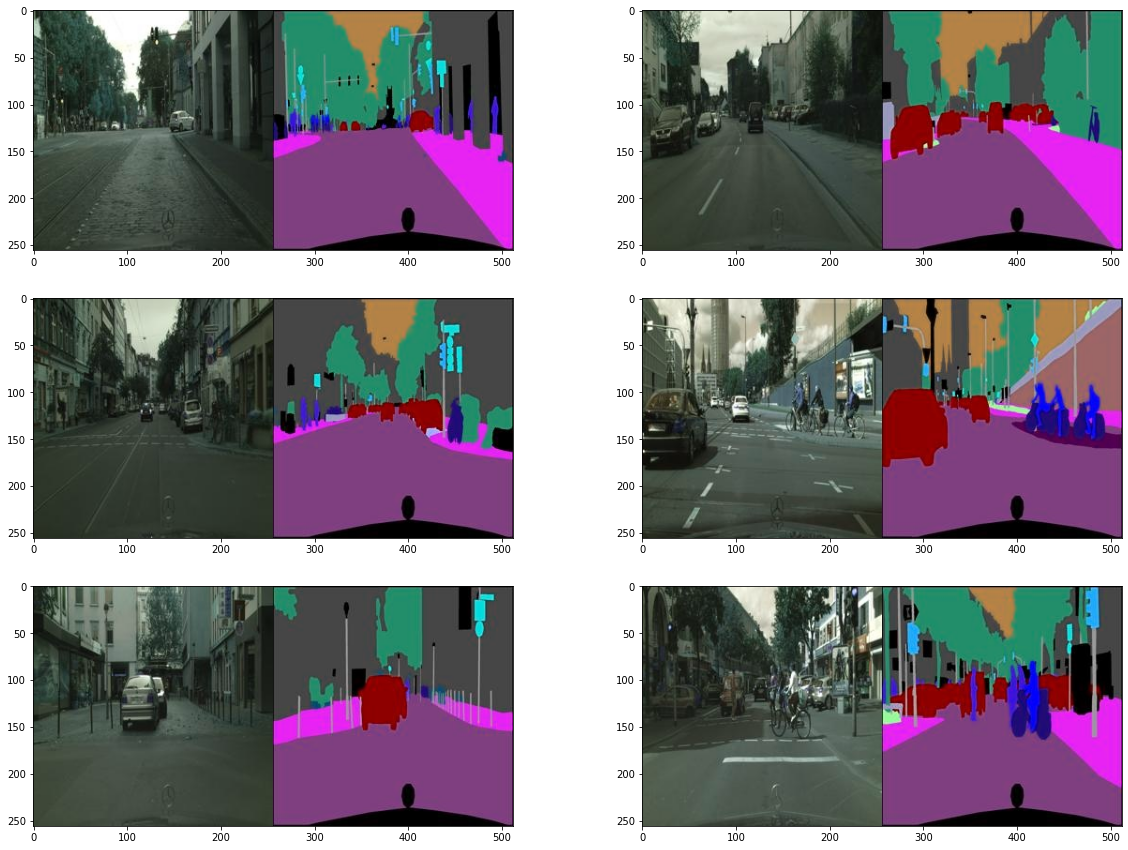

In [3]:
plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

이미지를 하나 열어 크기를 확인해보자.

In [4]:
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


모델 학습에 사용할 데이터를 (256, 256, 3) 크기의 2개 이미지로 분할하여 사용하면 될 것 같다.
<br> 이미지를 나누어 보자.

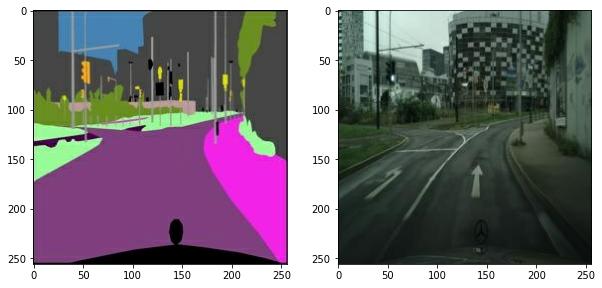

In [5]:
def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):  
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    real_image = img[:, :w, :] 
    real_image = tf.cast(real_image, tf.float32)
    input_image = img[:, w:, :] 
    input_image = tf.cast(input_image, tf.float32)
    return normalize(input_image), normalize(real_image)

f = data_path + os.listdir(data_path)[1]
input_image, real_image = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(input_image))
plt.subplot(1,2,2); plt.imshow(denormalize(real_image))

학습에 사용할 수 있는 데이터의 수는 1000개 뿐이므로, 다양성을 높이기 위해 augmentation 방법을 적용해보겠다. 이 때 segment 이미지와 실제 이미지 2개를 입력했을 때 동일한 연산이 적용되어야한다.

In [6]:
@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용
def apply_augmentation(input_image, real_image):
    stacked = tf.concat([input_image, real_image], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]

augmentation 적용 함수를 데이터에 적용해 시각화한다.

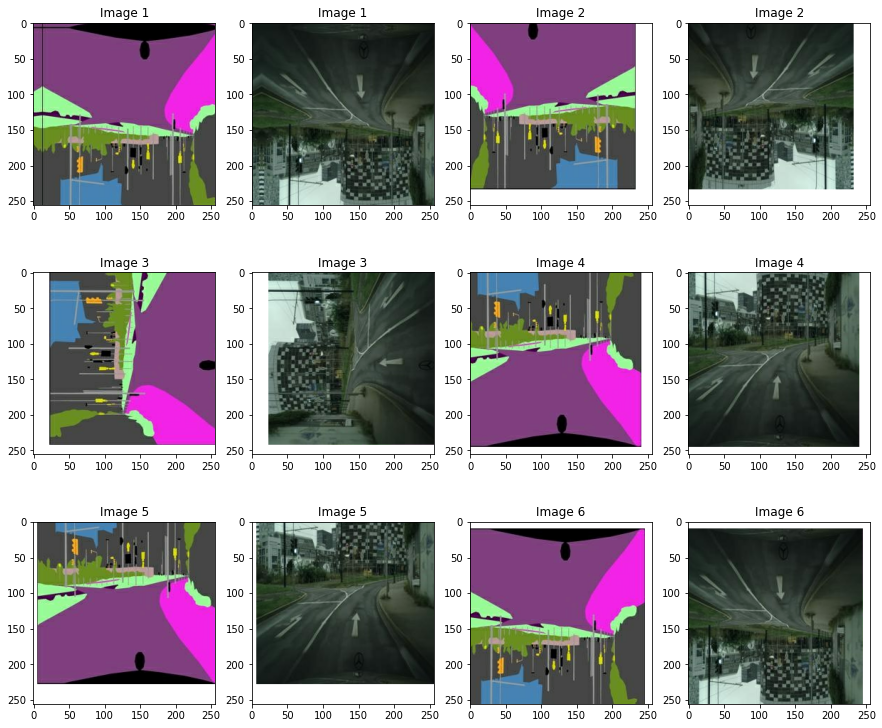

In [7]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_input, augmented_real = apply_augmentation(input_image, real_image)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_input)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_real)); plt.title(f"Image {img_n}")
    img_n += 1

이제 위에서 만들었던 함수들을 전체 데이터에 적용할 수 있는 새로운 함수를 만들어서 적용한 뒤, 하나의 이미지만 시각화하여 확인해보겠다.

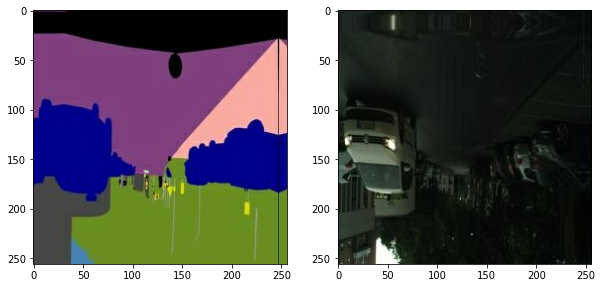

In [8]:
def get_train(img_path):
    input_image, real_image = load_img(img_path)
    input_image, real_image = apply_augmentation(input_image, real_image)
    return input_image, real_image

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
input_image, real_image = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(input_image[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(real_image[0].astype(np.uint8))

## 2. Generator 구성하기


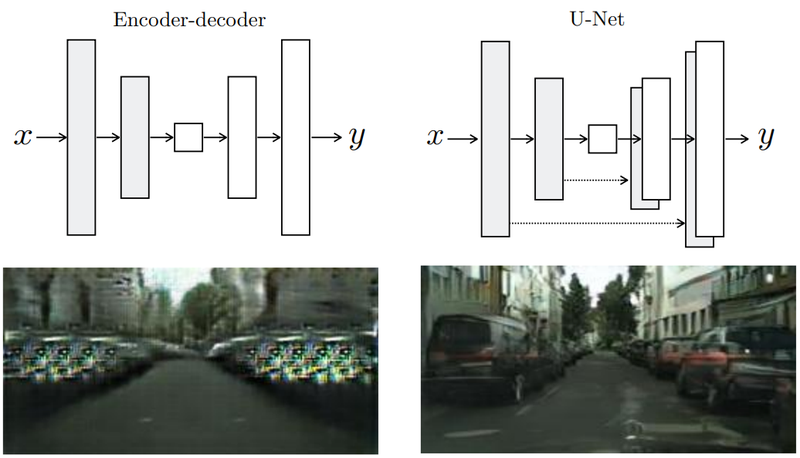

단순한 Encoder-Decoder 구조에 비해 Encoder와 Decoder 사이를 skip connection으로 연결한 U-Net 구조를 사용한 결과가 훨씬 더 실제 이미지에 가까운 품질을 보이므로, 여기서도 U-Net 구조를 만들어서 적용해보겠다.

먼저 Encoder와 Decoder에 사용되는 기본적인 블록을 구현해보자.

In [9]:
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

정의된 블록들을 이용해 U-Net Generator를 정의해보겠다.
<br> Encoder 및 Decoder에서 사용할 모든 블록들을 정의해놓고, call()에서 forward propagation 하도록 해준다.

In [10]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

init() 에서 정의된 encode_blocks 및 decode_blocks가 call() 내부에서 차례대로 사용되어 Encoder 및 Decoder 내부 연산을 수행한다.
<br>
이때, Encoder와 Decoder 사이의 skip connection을 위해 features 라는 리스트를 만들고 Encoder 내에서 사용된 각 블록들의 출력을 차례대로 담는다.
<br>
이후 Encoder의 최종 출력이 Decoder의 입력으로 들어가면서 다시 한번 각각의 Decoder 블록들을 통과하는데, features 리스트에 있는 각각의 출력들이 Decoder 블록 연산 후 함께 연결되어 다음 블록의 입력으로 사용된다.

In [11]:
UNetGenerator().get_summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block (EncodeBlock)      (None, 128, 128, 64) 3072        input_1[0][0]                    
__________________________________________________________________________________________________
encode_block_1 (EncodeBlock)    (None, 64, 64, 128)  131584      encode_block[0][0]               
__________________________________________________________________________________________________
encode_block_2 (EncodeBlock)    (None, 32, 32, 256)  525312      encode_block_1[0][0]             
______________________________________________________________________________________________

Encoder에 (256,256,3) 크기의 데이터를 입력하면 블록을 통과할수록 (width, height) 크기는 반씩 줄어들고 사용된 필터 수는 점점 늘어나 최종 (1,1,512) 크기로 출력된다.

Decoder에 (1,1,512) 크기의 데이터가 입력되면 (width, height) 크기는 2배씩 늘어나고 사용된 필터 수는 점점 줄어들어 최종 (256,256,3) 크기로 출력된다.

---
## 3. Discriminator 구성하기

Discriminator에 사용할 기본 블록부터 만들어보자.

In [12]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x

1. 입력이 layers.ZeroPadding2D()를 통과하면, width 및 height의 양쪽 면에 각각 1씩 패딩되어 총 2만큼 크기가 늘어난다.
2. 패딩하지 않고 필터 크기 4 및 간격(stride) 1의 convolution 레이어를 통과하면 width 및 height 가 3씩 줄어든다. 이는 OutSize=(InSize+2∗PadSize−FilterSize)/Stride+1 의 식으로 계산할 수 있다. 채널 수는 사용한 필터 개수와 같다.
3. 이 외 다른 레이어(BatchNorm, LeakyReLU)는 출력의 크기에 영향을 주지 않는다.

Discriminator를 정의해보자.

In [13]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # < for문 이용한 블록 생성 >
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()

첫 번째 블록은 단순한 연결(concat)을 수행하며, Discriminator의 최종 출력은 sigmoid 활성화를 사용한다.

In [14]:
Discriminator().get_summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 256, 256, 6)  0           input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
disc_block (DiscBlock)          (None, 128, 128, 64) 6144        concatenate_7[0][0]        

Pix2Pix의 Discriminator가 70x70 PatchGAN을 사용하기 때문에 최종 출력을 (30,30) 크기로 맞춰주었다. (256,256,3) 크기의 입력을 넣으면 (30,30,1) 크기의 이미지가 출력된다.
<br> 시험 삼아 임의의 (256,256,3) 크기의 입력을 넣어서 나오는 (30,30,1) 출력을 시각화해보자.

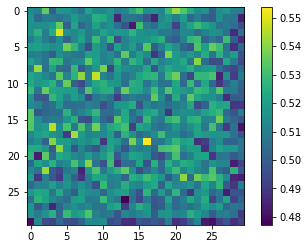

In [15]:
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

위 (30,30) 크기를 갖는 결과 이미지의 각 픽셀 값은 원래 입력의 (70,70) 패치에 대한 분류 결과이다. 전체 입력의 크기가 (256,256) 이므로, 각각의 (70,70) 패치는 원래 입력상에서 많이 겹쳐있다. 각각의 픽셀 값은 sigmoid 함수의 결괏값이므로 0~1 사이의 값을 가지며, 진짜 및 가짜 데이터를 판별해 내는 데 사용한다.

---
## 4. 학습 및 테스트하기

#### 1) 손실함수 정의

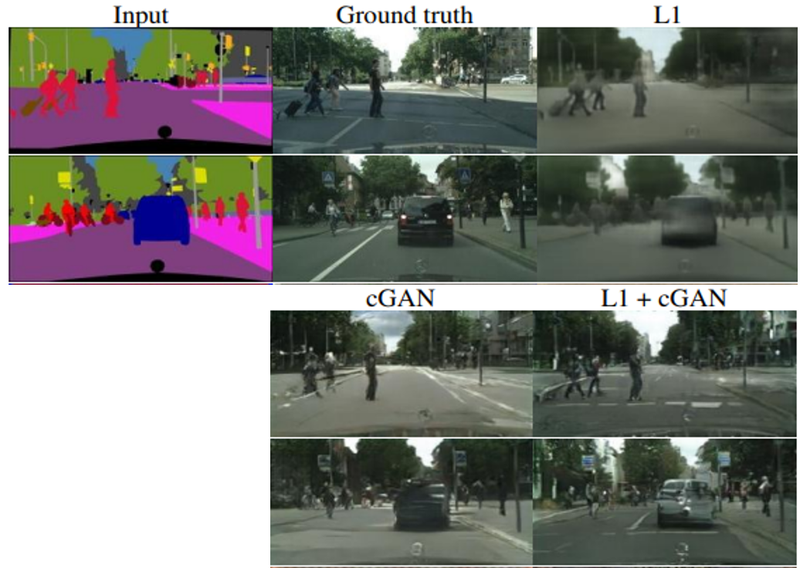

논문의 여러 실험 결과 중 손실 함수 선택에 따른 결과의 차이는 위와 같다. 레이블 정보만 있는 입력에 대해 여러 손실함수를 사용하여 실제 이미지를 만들어 낸 결과를 따져봤을 때, 일반적인 GAN의 손실함수에 L1 손실함수를 추가로 이용했을 때 가장 실제에 가까운 이미지를 생성해냈으므로, 여기서도 두 가지 손실함수를 모두 사용해보겠다.

In [16]:
bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

# Generator의 손실함수
def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

# Discriminator의 손실함수
def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)


- Generator의 손실 함수 (위 코드의 get_gene_loss)는 총 3개의 입력이 있다. 이 중 fake_disc는 Generator가 생성한 가짜 이미지를 Discriminator에 입력하여 얻어진 값이며, 실제 이미지를 뜻하는 "1"과 비교하기 위해 tf.ones_like()를 사용한다. 또한 L1 손실을 계산하기 위해 생성한 가짜 이미지(fake_output)와 실제 이미지(real_output) 사이의 MAE(Mean Absolute Error)를 계산한다.

- Discriminator의 손실 함수 (위 코드의 get_disc_loss)는 2개의 입력이 있으며, 이들은 가짜 및 진짜 이미지가 Discriminator에 각각 입력되어 얻어진 값이다. Discriminator는 실제 이미지를 잘 구분해 내야 하므로 real_disc는 "1"로 채워진 벡터와 비교하고, fake_disc는 "0"으로 채워진 벡터와 비교한다.

#### 2) Optimizer 및 train_step 정의

In [17]:
# Optimizer 정의
gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

In [18]:
# 하나의 배치 크기만큼 데이터를 입력했을 때 가중치를 1회 업데이트하는 과정
@tf.function
def train_step(input_image, real_image):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        gen_output = generator(input_image, training=True)
        # Discriminator 예측
        fake_disc = discriminator(input_image, gen_output, training=True)
        real_disc = discriminator(input_image, real_image, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(gen_output, real_image, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

#### 3) 학습 진행

실습에 언급되었던 128 epochs로 학습을 진행해보자.

In [19]:
EPOCHS = 128

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (input_image, real_image) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(input_image, real_image)

        # 각 Epochs 마다 손실을 출력
        if (i+1) % 200 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[200]                     
Generator_loss:1.4426                     
L1_loss:0.1640                     
Discriminator_loss:0.7015

EPOCH[2] - STEP[200]                     
Generator_loss:1.9818                     
L1_loss:0.1642                     
Discriminator_loss:0.3697

EPOCH[3] - STEP[200]                     
Generator_loss:1.3233                     
L1_loss:0.1676                     
Discriminator_loss:0.7599

EPOCH[4] - STEP[200]                     
Generator_loss:0.1062                     
L1_loss:0.2222                     
Discriminator_loss:2.9495

EPOCH[5] - STEP[200]                     
Generator_loss:0.9683                     
L1_loss:0.1909                     
Discriminator_loss:1.0393

EPOCH[6] - STEP[200]                     
Generator_loss:1.0350                     
L1_loss:0.1692                     
Discriminator_loss:0.8397

EPOCH[7] - STEP[200]                     
Generator_loss:0.5475                     
L1_loss:0.2020             

EPOCH[57] - STEP[200]                     
Generator_loss:1.3537                     
L1_loss:0.1723                     
Discriminator_loss:0.4790

EPOCH[58] - STEP[200]                     
Generator_loss:1.7428                     
L1_loss:0.1572                     
Discriminator_loss:1.6012

EPOCH[59] - STEP[200]                     
Generator_loss:2.1087                     
L1_loss:0.1801                     
Discriminator_loss:0.2449

EPOCH[60] - STEP[200]                     
Generator_loss:1.8680                     
L1_loss:0.1684                     
Discriminator_loss:0.8666

EPOCH[61] - STEP[200]                     
Generator_loss:1.4443                     
L1_loss:0.1834                     
Discriminator_loss:0.7443

EPOCH[62] - STEP[200]                     
Generator_loss:1.8947                     
L1_loss:0.1677                     
Discriminator_loss:0.6633

EPOCH[63] - STEP[200]                     
Generator_loss:1.5246                     
L1_loss:0.1815      

EPOCH[112] - STEP[200]                     
Generator_loss:1.8056                     
L1_loss:0.1765                     
Discriminator_loss:0.8386

EPOCH[113] - STEP[200]                     
Generator_loss:3.0475                     
L1_loss:0.1685                     
Discriminator_loss:1.2700

EPOCH[114] - STEP[200]                     
Generator_loss:1.0179                     
L1_loss:0.1710                     
Discriminator_loss:0.9212

EPOCH[115] - STEP[200]                     
Generator_loss:1.1812                     
L1_loss:0.1965                     
Discriminator_loss:0.5039

EPOCH[116] - STEP[200]                     
Generator_loss:2.3747                     
L1_loss:0.1658                     
Discriminator_loss:1.3823

EPOCH[117] - STEP[200]                     
Generator_loss:1.2371                     
L1_loss:0.1626                     
Discriminator_loss:0.7909

EPOCH[118] - STEP[200]                     
Generator_loss:0.5094                     
L1_loss:0.176

#### 4) 테스트 진행

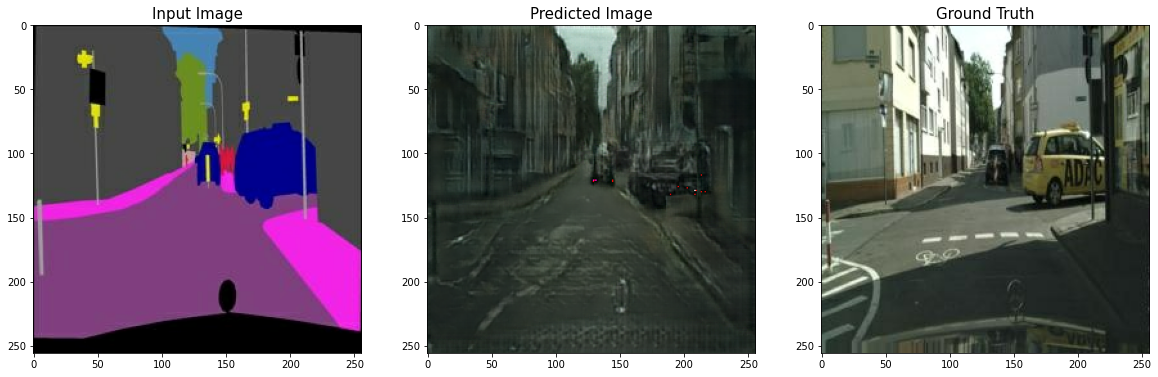

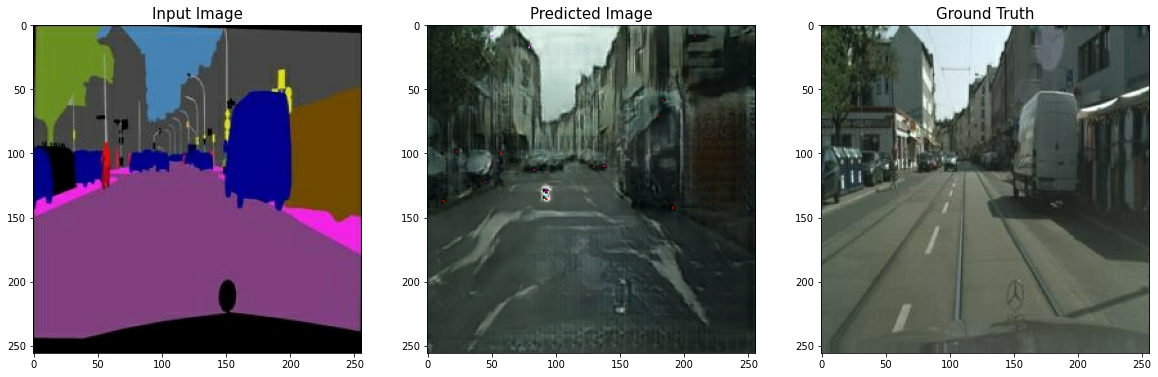

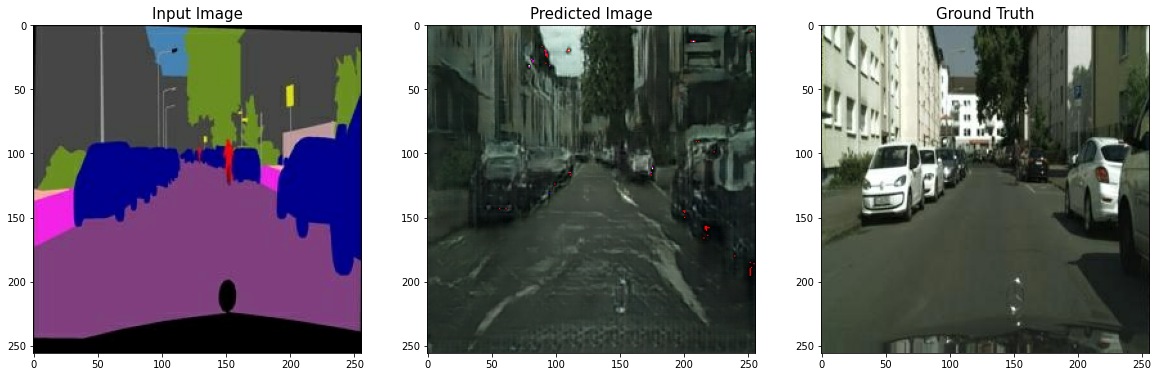

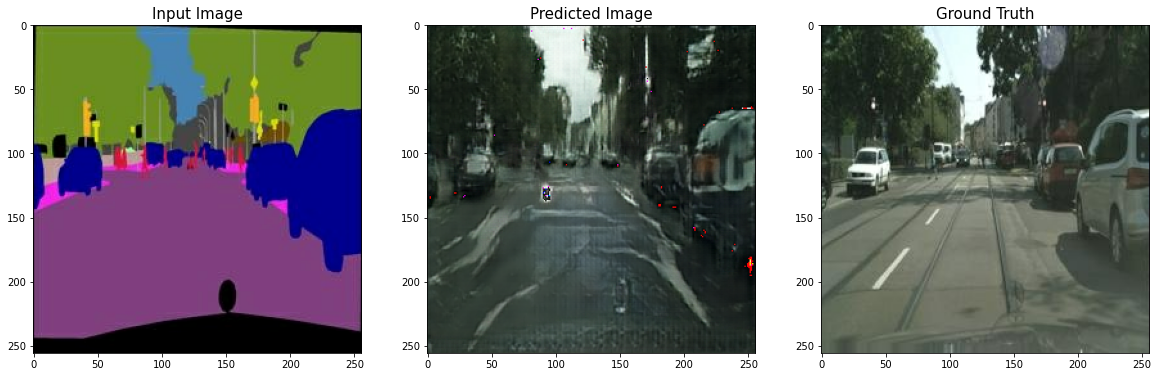

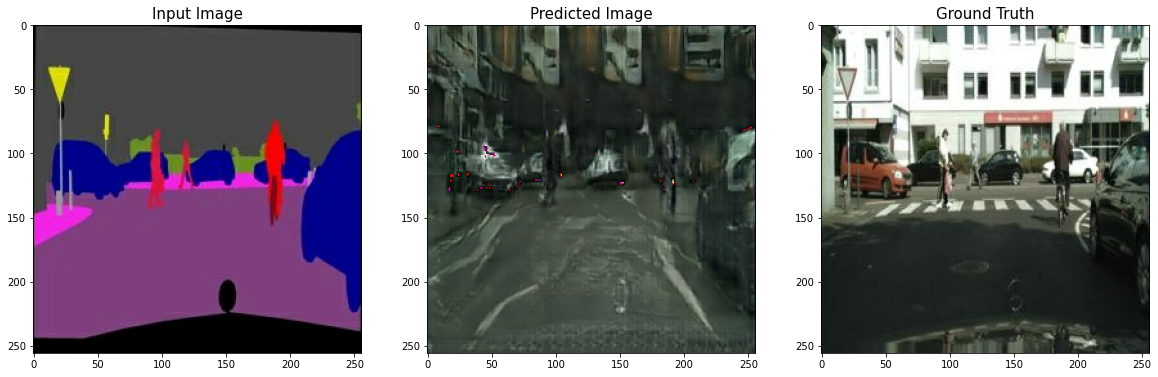

In [21]:
test_path = os.getenv('HOME')+'/aiffel/conditional_generation/cityscapes/val/'

for i in range(5):
    f = test_path + os.listdir(test_path)[i]
    input_image, real_image = load_img(f)

    pred = generator(tf.expand_dims(input_image, 0))
    pred = denormalize(pred)

    plt.figure(figsize=(20,10))
    plt.subplot(1,3,1); plt.imshow(denormalize(input_image)); plt.title('Input Image', fontsize=15)
    plt.subplot(1,3,2); plt.imshow(pred[0]); plt.title('Predicted Image', fontsize=15)
    plt.subplot(1,3,3); plt.imshow(denormalize(real_image)); plt.title('Ground Truth', fontsize=15)


---
## 회고

- 실습에서 제시한 128 Epochs으로 돌려봤는데 그래도 어느 정도 형체는 알아볼 수 있는 이미지가 생성된 것 같다. 시간이 많았다면 500 Epochs 정도 돌리고 제대로 된 결과물을 낼 수 있을 것 같은데, 시간이 부족해서 하지 못했다. 다음에 GAN 공부를 추가로 할 때 많은 Epochs수로 실험을 다시 해봐야겠다.
<br><br>
- 이번 노드는 무언가 새로 추가하지 못했다. 데이터셋에 대해서도 Augmentation을 추가로 해볼 수 있고, U-Net 구조가 아닌 단순한 Encoder-Decoder 모델을 돌려보고 차이점에 대해서도 비교해볼 수 있었을 것이다. 또한 모델 구성에 있어서도 여러가지 다양한 방법을 시도해볼 수 있었을텐데, 시간에 쫓기고 다른 할 것들이 많다는 핑계로 하지 못했다. 그렇지만 앞으로 GAN에 대해 더 공부하고 싶은 마음이 큰 만큼, 나중에 이 프로젝트를 꼭 다시 시행해보고 그 때 여러가지 시도를 추가적으로 해보면 좋겠다는 생각이 들었다. 다른 종류의 스케치들을 input으로 넣고 채색된 이미지를 생성해내는 시도도 그 때 꼭 해야겠다.
<br><br>
- 마지막 exploration 노드 프로젝트였는데 생각보다 결과가 별로였고 재미도 덜해서 아쉬웠지만, 나름대로 exploration 프로젝트들을 빠짐없이 꾸준하게 완성했다는 데에서 오는 뿌듯함이 있다. 앞으로 Going Deeper 노드에서 더 실력을 쌓고 나중에 Exploration 프로젝트들을 복습할 때 꼭 다시 의미를 찾고 내 실력을 키울 수 있는 밑거름들이 되었으면 좋겠다.